# Recurrent Neural Networks for character-level language modeling

Github: https://github.com/sherjilozair/char-rnn-tensorflow

karpathy's Blog: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

## Task Introduction

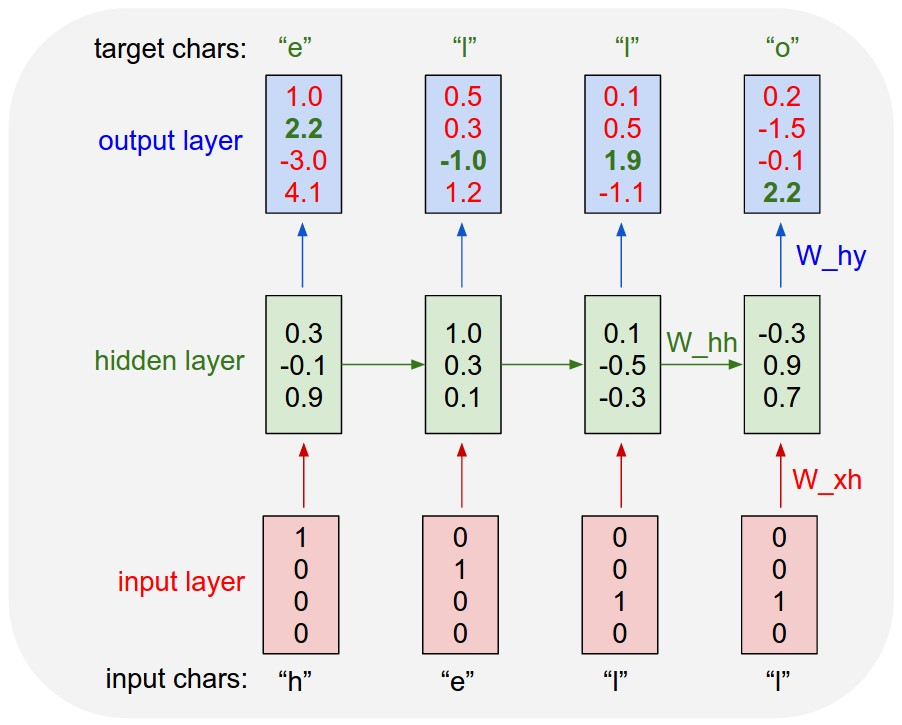

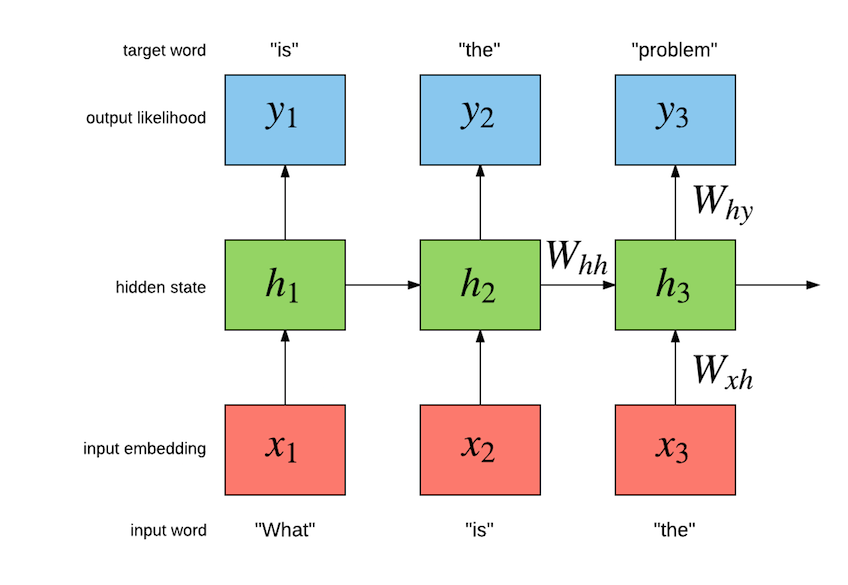

### Input

A list of characters (or words) indicates the prefix of a language text.

Eg. 1: "Hell"

Eg. 2: "What is the"

### Output

A classification result (in the form of logits or a softmax distribution over vocabulary) indicates the probability distribution of the next character (or words).

### Utils

In [1]:
import codecs
import os
import collections
from six.moves import cPickle
import numpy as np


class TextLoader():
    def __init__(self, data_dir, batch_size, seq_length, encoding='utf-8'):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.encoding = encoding

        input_file = os.path.join(data_dir, "input.txt")
        vocab_file = os.path.join(data_dir, "vocab.pkl")
        tensor_file = os.path.join(data_dir, "data.npy")

        if not (os.path.exists(vocab_file) and os.path.exists(tensor_file)):
            print("reading text file")
            self.preprocess(input_file, vocab_file, tensor_file)
        else:
            print("loading preprocessed files")
            self.load_preprocessed(vocab_file, tensor_file)
        self.create_batches()
        self.reset_batch_pointer()

    # preprocess data for the first time.
    def preprocess(self, input_file, vocab_file, tensor_file):
        with codecs.open(input_file, "r", encoding=self.encoding) as f:
            data = f.read()
        counter = collections.Counter(data)
        count_pairs = sorted(counter.items(), key=lambda x: -x[1])
        self.chars, _ = zip(*count_pairs)
        self.vocab_size = len(self.chars)
        self.vocab = dict(zip(self.chars, range(len(self.chars))))
        with open(vocab_file, 'wb') as f:
            cPickle.dump(self.chars, f)
        self.tensor = np.array(list(map(self.vocab.get, data)))
        np.save(tensor_file, self.tensor)


    # load the preprocessed the data if the data has been processed before.
    def load_preprocessed(self, vocab_file, tensor_file):
        with open(vocab_file, 'rb') as f:
            self.chars = cPickle.load(f)
        self.vocab_size = len(self.chars)
        self.vocab = dict(zip(self.chars, range(len(self.chars))))
        self.tensor = np.load(tensor_file)
        self.num_batches = int(self.tensor.size / (self.batch_size *
                                                   self.seq_length))
    # seperate the whole data into different batches.
    def create_batches(self):
        self.num_batches = int(self.tensor.size / (self.batch_size *
                                                   self.seq_length))

        # When the data (tensor) is too small,
        # let's give them a better error message
        if self.num_batches == 0:
            assert False, "Not enough data. Make seq_length and batch_size small."

        # reshape the original data into the length self.num_batches * self.batch_size * self.seq_length for convenience.
        self.tensor = self.tensor[:self.num_batches * self.batch_size * self.seq_length]
        xdata = self.tensor
        ydata = np.copy(self.tensor)

        #ydata is the xdata with one position shift.
        ydata[:-1] = xdata[1:]
        ydata[-1] = xdata[0]
        self.x_batches = np.split(xdata.reshape(self.batch_size, -1),
                                  self.num_batches, 1)
        self.y_batches = np.split(ydata.reshape(self.batch_size, -1),
                                  self.num_batches, 1)

    def next_batch(self):
        x, y = self.x_batches[self.pointer], self.y_batches[self.pointer]
        self.pointer += 1
        return x, y

    def reset_batch_pointer(self):
        self.pointer = 0

## Model Description

### Rnn Cell (Line 15 - 25)

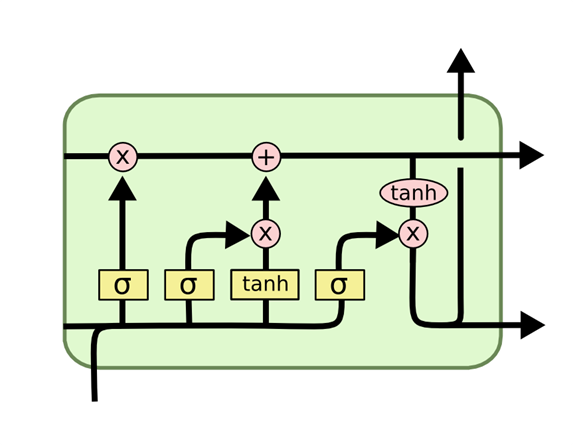

You may try different rnn cells other than lstm.

Tunable hyper parameters:

    model
    
### Cell Wrapper (Line 27 - 36)

Tunable hyper parameters:

    num_layers
    rnn_size
    input_keep_prob
    output_keep_prob

Dropout inside rnn cells is very tricky. https://arxiv.org/pdf/1603.05118.pdf

### Input and Embedding Lookup Layer (Line 38 - 47)

Embedding size is the same as rnn_size above.

### Dropout Layer (Line 49 - 51)

The keep probability in Dropout Layer is the same as output_keep_prob above.

### RNN Layer (Line 63 - 74)

How does rnn work: https://www.tensorflow.org/api_docs/python/tf/nn/raw_rnn

### Output Layer (Line 76 - 78)

### Loss and Gradient Calculation (Line 80 - 98)

Log loss is the same as cross entropy loss.

You may use optimizers other than adam (Line 95).

In [2]:
import tensorflow as tf
from tensorflow.contrib import rnn
from tensorflow.contrib import legacy_seq2seq

import numpy as np


class Model():
    def __init__(self, args, training=True,):
        self.args = args
        if not training:
            args.batch_size = 1
            args.seq_length = 1

        # choose different rnn cell 
        if args.model == 'rnn':
            cell_fn = rnn.RNNCell
        elif args.model == 'gru':
            cell_fn = rnn.GRUCell
        elif args.model == 'lstm':
            cell_fn = rnn.LSTMCell
        elif args.model == 'nas':
            cell_fn = rnn.NASCell
        else:
            raise Exception("model type not supported: {}".format(args.model))

        # wrap multi layered rnn cell into one cell with dropout
        cells = []
        for _ in range(args.num_layers):
            cell = cell_fn(args.rnn_size)
            if training and (args.output_keep_prob < 1.0 or args.input_keep_prob < 1.0):
                cell = rnn.DropoutWrapper(cell,
                                          input_keep_prob=args.input_keep_prob,
                                          output_keep_prob=args.output_keep_prob)
            cells.append(cell)
        self.cell = cell = rnn.MultiRNNCell(cells, state_is_tuple=True)

        # input/target data (int32 since input is char-level)
        self.input_data = tf.placeholder(
            tf.int32, [args.batch_size, args.seq_length])
        self.targets = tf.placeholder(
            tf.int32, [args.batch_size, args.seq_length])
        self.initial_state = cell.zero_state(args.batch_size, tf.float32)

        # transform input to embedding
        embedding = tf.get_variable("embedding", [args.vocab_size, args.rnn_size])
        inputs = tf.nn.embedding_lookup(embedding, self.input_data)

        # dropout beta testing: double check which one should affect next line
        if training and args.output_keep_prob:
            inputs = tf.nn.dropout(inputs, args.output_keep_prob)

        # unstack the input to fits in rnn model
        inputs = tf.split(inputs, args.seq_length, 1)
        inputs = [tf.squeeze(input_, [1]) for input_ in inputs]

        # softmax output layer, use softmax to classify
        with tf.variable_scope('rnnlm'):
            softmax_w = tf.get_variable("softmax_w",
                                        [args.rnn_size, args.vocab_size])
            softmax_b = tf.get_variable("softmax_b", [args.vocab_size])
        
        # loop function for rnn_decoder, which take the previous i-th cell's output 
        # and generate the (i+1)-th cell's input
        def loop(prev, _):
            prev = tf.matmul(prev, softmax_w) + softmax_b
            prev_symbol = tf.stop_gradient(tf.argmax(prev, 1))
            return tf.nn.embedding_lookup(embedding, prev_symbol)

        # rnn_decoder to generate the ouputs and final state. When we are not training the model, 
        # we use the loop function.
        outputs, last_state = legacy_seq2seq.rnn_decoder(inputs, self.initial_state, cell, 
                                                         loop_function=loop if not training else None, scope='rnnlm')
        output = tf.reshape(tf.concat(outputs, 1), [-1, args.rnn_size])

        # output layer
        self.logits = tf.matmul(output, softmax_w) + softmax_b
        self.probs = tf.nn.softmax(self.logits)

        # loss is calculate by the log loss and taking the average.
        loss = legacy_seq2seq.sequence_loss_by_example(
                [self.logits],
                [tf.reshape(self.targets, [-1])],
                [tf.ones([args.batch_size * args.seq_length])])
        with tf.name_scope('cost'):
            self.cost = tf.reduce_sum(loss) / args.batch_size / args.seq_length
        self.final_state = last_state
        self.lr = tf.Variable(0.0, trainable=False)
        tvars = tf.trainable_variables()

        # calculate gradients
        grads, _ = tf.clip_by_global_norm(tf.gradients(self.cost, tvars),
                args.grad_clip)
        with tf.name_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(self.lr)

        # apply gradient change to the all the trainable variable.
        self.train_op = optimizer.apply_gradients(zip(grads, tvars))

        # instrument tensorboard
        tf.summary.histogram('logits', self.logits)
        tf.summary.histogram('loss', loss)
        tf.summary.scalar('train_loss', self.cost)

    def sample(self, sess, chars, vocab, num=200, prime='The ', sampling_type=1):
        state = sess.run(self.cell.zero_state(1, tf.float32))
        for char in prime[:-1]:
            x = np.zeros((1, 1))
            x[0, 0] = vocab[char]
            feed = {self.input_data: x, self.initial_state: state}
            [state] = sess.run([self.final_state], feed)

        def weighted_pick(weights):
            t = np.cumsum(weights)
            s = np.sum(weights)
            return(int(np.searchsorted(t, np.random.rand(1)*s)))

        ret = prime
        char = prime[-1]
        for _ in range(num):
            x = np.zeros((1, 1))
            x[0, 0] = vocab[char]
            feed = {self.input_data: x, self.initial_state: state}
            [probs, state] = sess.run([self.probs, self.final_state], feed)
            p = probs[0]

            if sampling_type == 0:
                sample = np.argmax(p)
            elif sampling_type == 2:
                if char == ' ':
                    sample = weighted_pick(p)
                else:
                    sample = np.argmax(p)
            else:  # sampling_type == 1 default:
                sample = weighted_pick(p)

            pred = chars[sample]
            ret += pred
            char = pred
        return ret

### Train

Some tunable training hyper parameters which may influence the results:

    seq_length
    batch_size
    num_epochs
    grad_clip
    learning_rate
    decay_rate

All the tunable hyper parameters can be tuned here.

In [3]:
#!/usr/bin/env python

from __future__ import print_function

import argparse
import time
import os
from six.moves import cPickle
import tensorflow as tf

# Data and model checkpoints directories

tf.flags.DEFINE_string('data_dir', 'data/tinyshakespeare', 'data directory containing input.txt with training examples')
tf.flags.DEFINE_string('save_dir', 'save', 'directory to store checkpointed models')
tf.flags.DEFINE_string('log_dir', 'logs', 'directory to store tensorboard logs')
tf.flags.DEFINE_integer('save_every', 50, 'Save frequency. Number of passes between checkpoints of the model.')
tf.flags.DEFINE_string('init_from', None, "continue training from saved model at this path.")

# Model params

tf.flags.DEFINE_string('model', 'lstm', 'lstm, rnn, gru, or nas')
tf.flags.DEFINE_integer('rnn_size', 128, 'size of RNN hidden state')
tf.flags.DEFINE_integer('num_layers', 2, 'number of layers in the RNN')

# Optimization

tf.flags.DEFINE_integer('seq_length', 50, 'RNN sequence length. Number of timesteps to unroll for.')
tf.flags.DEFINE_integer('batch_size', 50, 'minibatch size.')
tf.flags.DEFINE_integer('num_epochs', 10, 'number of epochs. Number of full passes through the training examples.')
tf.flags.DEFINE_float('grad_clip', 5., 'clip gradients at this value')
tf.flags.DEFINE_float('learning_rate', 0.002, 'learning rate')
tf.flags.DEFINE_float('decay_rate', 0.97, 'decay rate for rmsprop')
tf.flags.DEFINE_float('output_keep_prob', 1.0, 'probability of keeping weights in the hidden layer')
tf.flags.DEFINE_float('input_keep_prob', 1.0, 'probability of keeping weights in the input layer')
tf.flags.DEFINE_integer('vocab_size', None, 'vocabulary size in the training data')

# Sampling and Testing

tf.flags.DEFINE_integer('n', 50, 'number of characters to sample')
tf.flags.DEFINE_string('prime', u' ', 'prime text')
tf.flags.DEFINE_integer('sample', 1, '0 to use max at each timestep, 1 to sample at each timestep, 2 to sample on spaces')

args = tf.flags.FLAGS

def main(argv=None):
    data_loader = TextLoader(args.data_dir, args.batch_size, args.seq_length)
    args.vocab_size = data_loader.vocab_size
    print(args.vocab_size)

    
    # check compatibility if training is continued from previously saved model
    if args.init_from is not None:
        # check if all necessary files exist
        assert os.path.isdir(args.init_from)," %s must be a a path" % args.init_from
        assert os.path.isfile(os.path.join(args.init_from,"config.pkl")),"config.pkl file does not exist in path %s"%args.init_from
        assert os.path.isfile(os.path.join(args.init_from,"chars_vocab.pkl")),"chars_vocab.pkl.pkl file does not exist in path %s" % args.init_from
        ckpt = tf.train.latest_checkpoint(args.init_from)
        assert ckpt, "No checkpoint found"

        # open old config and check if models are compatible
        with open(os.path.join(args.init_from, 'config.pkl'), 'rb') as f:
            saved_model_args = cPickle.load(f)
        need_be_same = ["model", "rnn_size", "num_layers", "seq_length"]
        for checkme in need_be_same:
            assert vars(saved_model_args)[checkme]==vars(args)[checkme],"Command line argument and saved model disagree on '%s' "%checkme

        # open saved vocab/dict and check if vocabs/dicts are compatible
        with open(os.path.join(args.init_from, 'chars_vocab.pkl'), 'rb') as f:
            saved_chars, saved_vocab = cPickle.load(f)
        assert saved_chars==data_loader.chars, "Data and loaded model disagree on character set!"
        assert saved_vocab==data_loader.vocab, "Data and loaded model disagree on dictionary mappings!"

    if not os.path.isdir(args.save_dir):
        os.makedirs(args.save_dir)
    with open(os.path.join(args.save_dir, 'config.pkl'), 'wb') as f:
        cPickle.dump(args, f)
    with open(os.path.join(args.save_dir, 'chars_vocab.pkl'), 'wb') as f:
        cPickle.dump((data_loader.chars, data_loader.vocab), f)

    model = Model(args)

    with tf.Session() as sess:
        # instrument for tensorboard
        summaries = tf.summary.merge_all()
        writer = tf.summary.FileWriter(
                os.path.join(args.log_dir, time.strftime("%Y-%m-%d-%H-%M-%S")))
        writer.add_graph(sess.graph)

        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver(tf.global_variables())
        # restore model
        if args.init_from is not None:
            saver.restore(sess, ckpt)
        for e in range(args.num_epochs):
            sess.run(tf.assign(model.lr,
                               args.learning_rate * (args.decay_rate ** e)))
            data_loader.reset_batch_pointer()
            state = sess.run(model.initial_state)
            for b in range(data_loader.num_batches):
                start = time.time()
                x, y = data_loader.next_batch()
                feed = {model.input_data: x, model.targets: y}
                for i, (c, h) in enumerate(model.initial_state):
                    feed[c] = state[i].c
                    feed[h] = state[i].h

                # instrument for tensorboard
                summ, train_loss, state, _ = sess.run([summaries, model.cost, model.final_state, model.train_op], feed)
                writer.add_summary(summ, e * data_loader.num_batches + b)

                end = time.time()
                print("{}/{} (epoch {}), train_loss = {:.3f}, time/batch = {:.3f}"
                      .format(e * data_loader.num_batches + b,
                              args.num_epochs * data_loader.num_batches,
                              e, train_loss, end - start))
                if (e * data_loader.num_batches + b) % args.save_every == 0\
                        or (e == args.num_epochs-1 and
                            b == data_loader.num_batches-1):
                    # save for the last result
                    checkpoint_path = os.path.join(args.save_dir, 'model.ckpt')
                    saver.save(sess, checkpoint_path,
                               global_step=e * data_loader.num_batches + b)
                    print("model saved to {}".format(checkpoint_path))
                                        
if __name__ == '__main__':
    tf.app.run()

loading preprocessed files
65
0/4460 (epoch 0), train_loss = 4.214, time/batch = 0.329
model saved to save/model.ckpt
1/4460 (epoch 0), train_loss = 4.174, time/batch = 0.088
2/4460 (epoch 0), train_loss = 4.074, time/batch = 0.069
3/4460 (epoch 0), train_loss = 3.837, time/batch = 0.067
4/4460 (epoch 0), train_loss = 3.597, time/batch = 0.051
5/4460 (epoch 0), train_loss = 3.533, time/batch = 0.060
6/4460 (epoch 0), train_loss = 3.454, time/batch = 0.062
7/4460 (epoch 0), train_loss = 3.397, time/batch = 0.055
8/4460 (epoch 0), train_loss = 3.342, time/batch = 0.060
9/4460 (epoch 0), train_loss = 3.420, time/batch = 0.063
10/4460 (epoch 0), train_loss = 3.322, time/batch = 0.064
11/4460 (epoch 0), train_loss = 3.345, time/batch = 0.064
12/4460 (epoch 0), train_loss = 3.331, time/batch = 0.056
13/4460 (epoch 0), train_loss = 3.302, time/batch = 0.057
14/4460 (epoch 0), train_loss = 3.371, time/batch = 0.065
15/4460 (epoch 0), train_loss = 3.364, time/batch = 0.058
16/4460 (epoch 0), tr

KeyboardInterrupt: 

### Evaluation

For evaluation, see "./sample.ipynb."